In [ ]:
!pip install transformers datasets torch scikit-learn pandas bs4 shap flask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import chardet

# Read a portion of the file to detect encoding
with open("/content/Phishing_Email.csv", 'rb') as f:
    result = chardet.detect(f.read(100000))
    print("Detected encoding:", result)

Detected encoding: {'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [ ]:

import numpy as np
import pandas as pd
import csv
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)
# df = pd.read_csv(
#     "/content/Phishing_Email.csv",
#     encoding='latin1',
#     on_bad_lines='skip',
#     quoting=csv.QUOTE_MINIMAL
# )

# df = pd.read_csv(
#     "/content/Phishing_Email.csv",
#     encoding='latin1',
#     quoting=csv.QUOTE_NONE,
#     on_bad_lines='skip',
#     error_bad_lines=False,  # for older pandas versions
#     engine='python'         # use the Python engine, which is more forgiving
# )

df = pd.read_csv(
    "/content/Phishing_Email.csv",
    encoding='latin1',
    quoting=csv.QUOTE_NONE,
    on_bad_lines='skip',       # skips malformed rows
    engine='python'            # fallback parser that handles messy data better
)



df.dropna(inplace=True)

df["label"] = df["Email Type"].apply(lambda x: 1 if x == "Phishing Email" else 0)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Email Text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=500,
    save_total_limit=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

trainer.evaluate()

{'eval_loss': 0.07385297864675522,
 'eval_runtime': 31.3703,
 'eval_samples_per_second': 118.807,
 'eval_steps_per_second': 7.427,
 'epoch': 3.0}

model.save_pretrained("./phishing_model")
tokenizer.save_pretrained("./phishing_model")


Using device:  cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.604861


('./phishing_model/tokenizer_config.json',
 './phishing_model/special_tokens_map.json',
 './phishing_model/vocab.txt',
 './phishing_model/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# /content/drive/MyDrive/seminar/Seminar/phishing_model

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the trained model and tokenizer
model_path = "/content/drive/MyDrive/Seminar-20250611T160623Z-1-001/Seminar/phishing_model"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")

# Set model to evaluation mode
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def predict(email_text):
    # Tokenize input text
    inputs = tokenizer(email_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    # Move tensors to appropriate device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get predicted label
    predicted_label = torch.argmax(probabilities, dim=-1).item()

    return "Phishing Email" if predicted_label == 1 else "Legitimate Email"
email_1 = "Dear User, your account has been compromised. Click the link below to verify your details."
email_2 = "Hi John, I hope you are doing well. Let's catch up for coffee next week."

print("Email 1 Prediction:", predict(email_1))  # Expected output: Phishing Email
print("Email 2 Prediction:", predict(email_2))  # Expected output: Legitimate Email


Email 1 Prediction: Phishing Email
Email 2 Prediction: Legitimate Email


In [ ]:
pip install --upgrade transformers


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.645700
20,0.531300
30,0.299800
40,0.314200
50,0.424900
60,0.295100
70,0.295500
80,0.311100
90,0.203600
100,0.236400


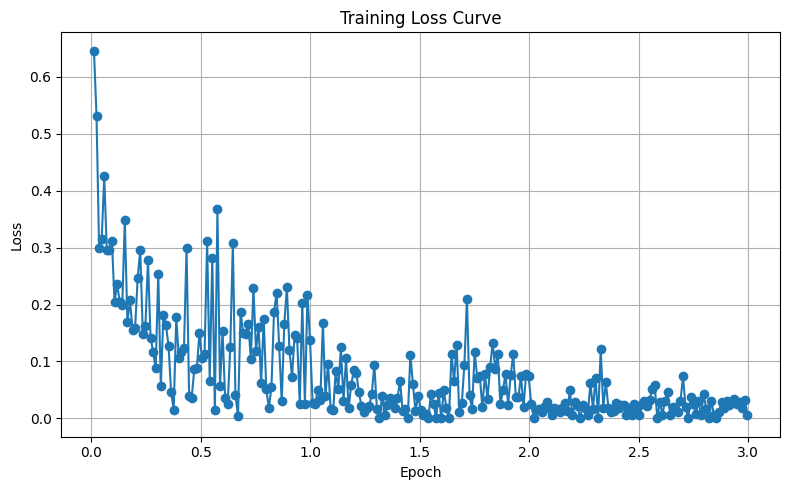

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
import numpy as np
import pandas as pd
import csv
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv(
    "/content/Phishing_Email.csv",
    encoding='latin1',
    on_bad_lines='skip',
    quoting=csv.QUOTE_MINIMAL
)

df.dropna(inplace=True)
df["label"] = df["Email Type"].apply(lambda x: 1 if x == "Phishing Email" else 0)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Email Text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels
})

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=1,
#     logging_dir="./logs",
#     logging_steps=10,
#     save_total_limit=2,
#     report_to="none"
# )
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10
)


# To store logs
# from transformers import TrainerCallback

# class LossLogger(TrainerCallback):
#     def _init_(self):
#         self.losses = []

#     def on_log(self, args, state, control, logs=None, **kwargs):
#         if "loss" in logs:
#             self.losses.append((state.epoch, logs["loss"]))
from transformers import TrainerCallback

class LossLogger(TrainerCallback):
    def __init__(self):  # <-- FIXED HERE
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.losses.append((state.epoch, logs["loss"]))


loss_logger = LossLogger()

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     callbacks=[loss_logger]
# )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[loss_logger]
)

trainer.train()

# Plot training loss over epochs
epochs, losses = zip(*loss_logger.losses)
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the model
model.save_pretrained("./phishing_model")
tokenizer.save_pretrained("./phishing_model")

# Predict on test set
test_inputs = tokenizer(test_texts, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
input_ids = test_inputs["input_ids"].to(device)
attention_mask = test_inputs["attention_mask"].to(device)

model.eval()

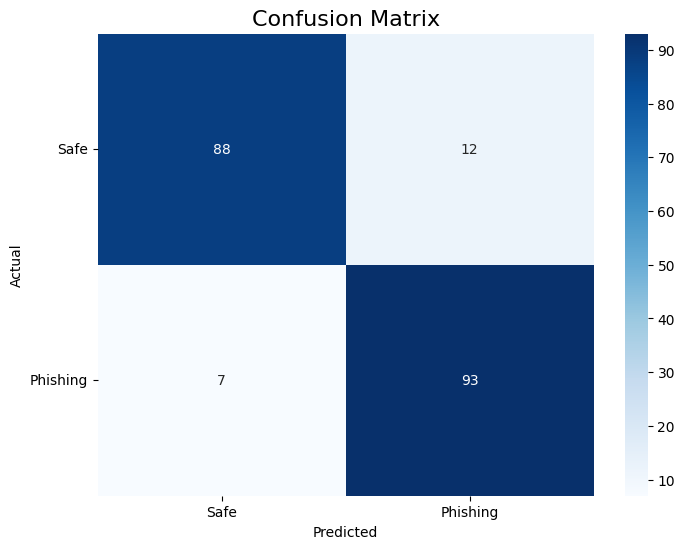

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hardcoded confusion matrix values
# Rows = Actual labels, Columns = Predicted labels
confusion_matrix = np.array([[88, 12],
                             [7, 93]])

# Class labels
labels = ['Safe', 'Phishing']

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()
